## **Import libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score, make_scorer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#TODO: SAVE EACH MODEL IN A SEPARATE FILE

## **Upload dataset**

In [2]:
#TODO: dane z gotowymi cechami -> czy próbować robić po swojemu ekstrakcję, skoro juz to zrobili?
dataset = pd.read_csv('masterTrain.csv')
dataset = dataset.iloc[:, 1:]
# 377010 x 34
# print(dataset.iloc[0:1,:])

In [3]:
from sklearn.model_selection import train_test_split

# Split dataset into users and impostors
num_classes = len(np.unique(dataset['class']))

user = {}
impostor = {}
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

for i in range(num_classes):
    user[i] = dataset.loc[dataset['class'] == i]
    impostor[i] = dataset.loc[dataset['class'] != i]
    # scale impostor to the same size as user
    impostor[i] = impostor[i].sample(n=len(user[i]))

    user[i].loc[:, 'class'] = 0
    impostor[i].loc[:, 'class'] = 1

    merged_data = pd.concat([user[i], impostor[i]])
    
    X = merged_data.loc[:, 'mean_x_speed':'numCritPoints']
    y = merged_data['class']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

#### Feature importance

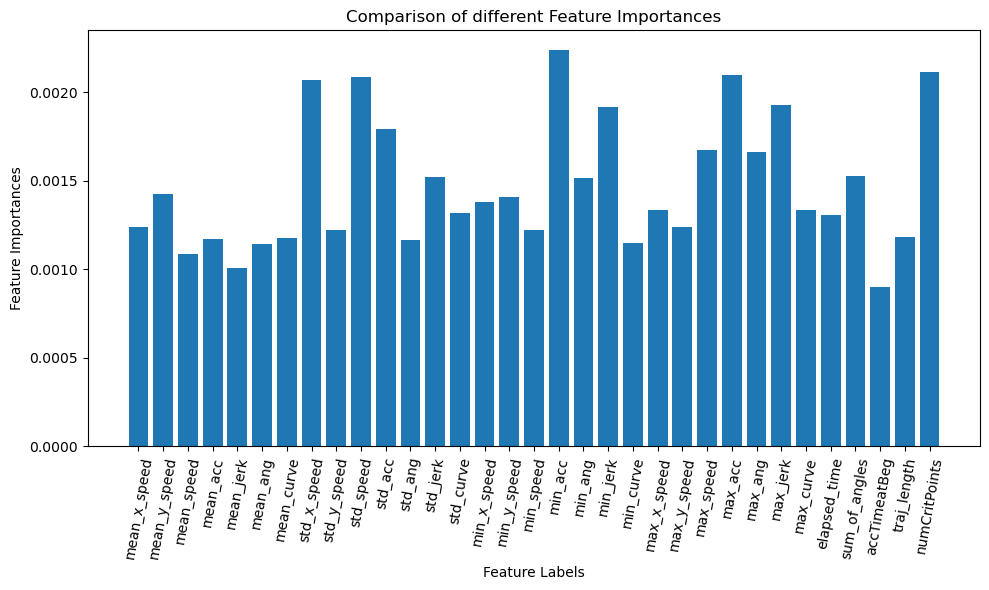

In [6]:
from sklearn.ensemble import ExtraTreesClassifier
extra_tree_forest = ExtraTreesClassifier()

extra_tree_forest.fit(X, y)

feature_importance = extra_tree_forest.feature_importances_

feature_importance_normalized = np.std([tree.feature_importances_ for tree in extra_tree_forest.estimators_], axis = 0)

plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importance_normalized)
plt.xticks(rotation=80)

plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.tight_layout()
plt.show()

# **Random Forest**

### Hyperparameters tuning

#### Randomized Search

In [4]:
from sklearn.ensemble import RandomForestClassifier
import random

best_models_random = []

hyperparams = {
        'n_estimators': [700, 750, 850], #TODO: np.arange(700, 1000, step=50), # tested: 100-500, step=100 -> best 500
        'max_depth': [None] + list(np.arange(50, 100, step=10)), # tested: 10-50, step=10
        'min_samples_split': [1, 2, 4], #TODO: [2, 4, 6, 8, 10],
        'min_samples_leaf': [1], #TODO: [1, 2, 4], 
        'criterion': ['entropy'], #TODO: ['gini','entropy'],
        'max_features': ['sqrt'], #TODO: ['log2', 'sqrt'],
        'bootstrap': [False] #TODO: [True, False]
    }

classes = list(range(num_classes))
random.shuffle(classes)
random_classes = classes[:]

for i in random_classes:
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    rf = RandomForestClassifier()

    random_search = RandomizedSearchCV(rf, hyperparams, cv=5, scoring='accuracy', n_jobs=-1, n_iter=10)
    random_search.fit(X_train, y_train)

    print('User ', i)
    print('Best hyperparams:', random_search.best_params_)
    print('Best score: ', random_search.best_score_)

    best_model = random_search.best_estimator_
    best_models_random.append(best_model)

    predictions = best_model.predict(X_test)

    print(classification_report(y_test, predictions))

C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\

User  0
Best hyperparams: {'n_estimators': 750, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'criterion': 'entropy', 'bootstrap': False}
Best score:  0.8095807068145797
Mean Squared Error: 0.16066145793825382
R-squared (R2): 0.35735416454918656
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      6591
           1       0.85      0.82      0.84      6592

    accuracy                           0.84     13183
   macro avg       0.84      0.84      0.84     13183
weighted avg       0.84      0.84      0.84     13183



C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package

User  8
Best hyperparams: {'n_estimators': 700, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'criterion': 'entropy', 'bootstrap': False}
Best score:  0.8111077694235588
Mean Squared Error: 0.16777608469003127
R-squared (R2): 0.32889565692342404
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      6235
           1       0.85      0.80      0.83      6234

    accuracy                           0.83     12469
   macro avg       0.83      0.83      0.83     12469
weighted avg       0.83      0.83      0.83     12469



C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package

User  1
Best hyperparams: {'n_estimators': 850, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'criterion': 'entropy', 'bootstrap': False}
Best score:  0.8173700787401575
Mean Squared Error: 0.15614764424288233
R-squared (R2): 0.3754094230284707
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      7938
           1       0.86      0.82      0.84      7938

    accuracy                           0.84     15876
   macro avg       0.84      0.84      0.84     15876
weighted avg       0.84      0.84      0.84     15876



C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package

User  7
Best hyperparams: {'n_estimators': 750, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}
Best score:  0.8170613737980915
Mean Squared Error: 0.1554597366274327
R-squared (R2): 0.3781610534902692
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      8581
           1       0.86      0.82      0.84      8581

    accuracy                           0.84     17162
   macro avg       0.85      0.84      0.84     17162
weighted avg       0.85      0.84      0.84     17162



C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package

User  9
Best hyperparams: {'n_estimators': 750, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}
Best score:  0.8117147192716236
Mean Squared Error: 0.16521000242777373
R-squared (R2): 0.3391599902889051
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      8238
           1       0.85      0.81      0.83      8238

    accuracy                           0.83     16476
   macro avg       0.84      0.83      0.83     16476
weighted avg       0.84      0.83      0.83     16476



C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package

User  2
Best hyperparams: {'n_estimators': 850, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90, 'criterion': 'entropy', 'bootstrap': False}
Best score:  0.8213025917336365
Mean Squared Error: 0.1482793867120954
R-squared (R2): 0.4068824503974877
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      7338
           1       0.86      0.83      0.85      7337

    accuracy                           0.85     14675
   macro avg       0.85      0.85      0.85     14675
weighted avg       0.85      0.85      0.85     14675



C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package

User  3
Best hyperparams: {'n_estimators': 750, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90, 'criterion': 'entropy', 'bootstrap': False}
Best score:  0.8138846135814128
Mean Squared Error: 0.1617490051441328
R-squared (R2): 0.35300397942346884
              precision    recall  f1-score   support

           0       0.81      0.88      0.84     10303
           1       0.87      0.80      0.83     10303

    accuracy                           0.84     20606
   macro avg       0.84      0.84      0.84     20606
weighted avg       0.84      0.84      0.84     20606



C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package

User  4
Best hyperparams: {'n_estimators': 850, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}
Best score:  0.8005267108978614
Mean Squared Error: 0.17772842639593908
R-squared (R2): 0.28908629441624367
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      7880
           1       0.86      0.77      0.81      7880

    accuracy                           0.82     15760
   macro avg       0.83      0.82      0.82     15760
weighted avg       0.83      0.82      0.82     15760



C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package

User  6
Best hyperparams: {'n_estimators': 750, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'criterion': 'entropy', 'bootstrap': False}
Best score:  0.8222169121448213
Mean Squared Error: 0.15740659725260303
R-squared (R2): 0.3703736061693724
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      5715
           1       0.86      0.82      0.84      5714

    accuracy                           0.84     11429
   macro avg       0.84      0.84      0.84     11429
weighted avg       0.84      0.84      0.84     11429



C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package

User  5
Best hyperparams: {'n_estimators': 700, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90, 'criterion': 'entropy', 'bootstrap': False}
Best score:  0.7879334862488993
Mean Squared Error: 0.18796022166552798
R-squared (R2): 0.24815910900520866
              precision    recall  f1-score   support

           0       0.83      0.78      0.81      6587
           1       0.79      0.84      0.82      6586

    accuracy                           0.81     13173
   macro avg       0.81      0.81      0.81     13173
weighted avg       0.81      0.81      0.81     13173



#### Grid Search

In [4]:
from sklearn.ensemble import RandomForestClassifier
import random

best_models_grid = []

hyperparams = {
        'n_estimators': list(np.arange(700, 800, step=10)),
        'max_depth': [None] + list(np.arange(70, 90, step=5)),
        'min_samples_split': [2],
        'min_samples_leaf': [1], 
        'criterion': ['entropy'],
        'max_features': ['sqrt'],
        'bootstrap': [False]
    }

classes = list(range(num_classes))
random.shuffle(classes)
random_classes = classes[:]

for i in random_classes:
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    rf = RandomForestClassifier()

    f1 = make_scorer(f1_score)

    grid_search = GridSearchCV(rf, hyperparams, cv=5, scoring=f1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print('User ', i)
    print('Best hyperparams:', grid_search.best_params_)
    print('Best score: ', grid_search.best_score_)

    best_model = grid_search.best_estimator_
    best_models_grid.append(best_model)

    predictions = best_model.predict(X_test)

    print(classification_report(y_test, predictions))

User  8
Best hyperparams: {'bootstrap': False, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 770}
Best score:  0.8043739893827496
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      6235
           1       0.85      0.81      0.83      6234

    accuracy                           0.83     12469
   macro avg       0.83      0.83      0.83     12469
weighted avg       0.83      0.83      0.83     12469

User  9
Best hyperparams: {'bootstrap': False, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 750}
Best score:  0.805057797475586
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      8238
           1       0.86      0.82      0.84      8238

    accuracy                           0.84     16476
   macro avg       0.84      0.84      0.84     16476
weighted avg

### Final model

In [31]:
from sklearn.ensemble import RandomForestClassifier

hyperparams = {
        'n_estimators': 740, # best from 720-760, 6/10 under 750, testes [720, 740, 760], best avg 740 (best avg f2)
        'max_depth': None, # allows for deeper trees to be grown, default
        'min_samples_split': 2, # default
        'min_samples_leaf': 1, # default
        'criterion': 'entropy',
        'max_features': 'sqrt', # default
        'bootstrap': False
    }

predictions_list = []

for i in range(num_classes):
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    rf = RandomForestClassifier(**hyperparams)
    rf.fit(X_train, y_train)

    predictions = rf.predict(X_test)
    predictions_list.append(predictions)

    f2_score = fbeta_score(y_test, predictions, beta=2)

    print("User: ", i)
    print(classification_report(y_test, predictions))
    print("F2 score: ", round(f2_score, 2))

User:  0
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      6592
           1       0.85      0.81      0.83      6591

    accuracy                           0.83     13183
   macro avg       0.83      0.83      0.83     13183
weighted avg       0.83      0.83      0.83     13183

F2 score:  0.82
User:  1
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      7938
           1       0.86      0.83      0.84      7938

    accuracy                           0.85     15876
   macro avg       0.85      0.85      0.85     15876
weighted avg       0.85      0.85      0.85     15876

F2 score:  0.84
User:  2
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      7337
           1       0.87      0.84      0.86      7338

    accuracy                           0.86     14675
   macro avg       0.86      0.86      0.86     14675
weighted avg   

Mean ROC AUC:  0.84


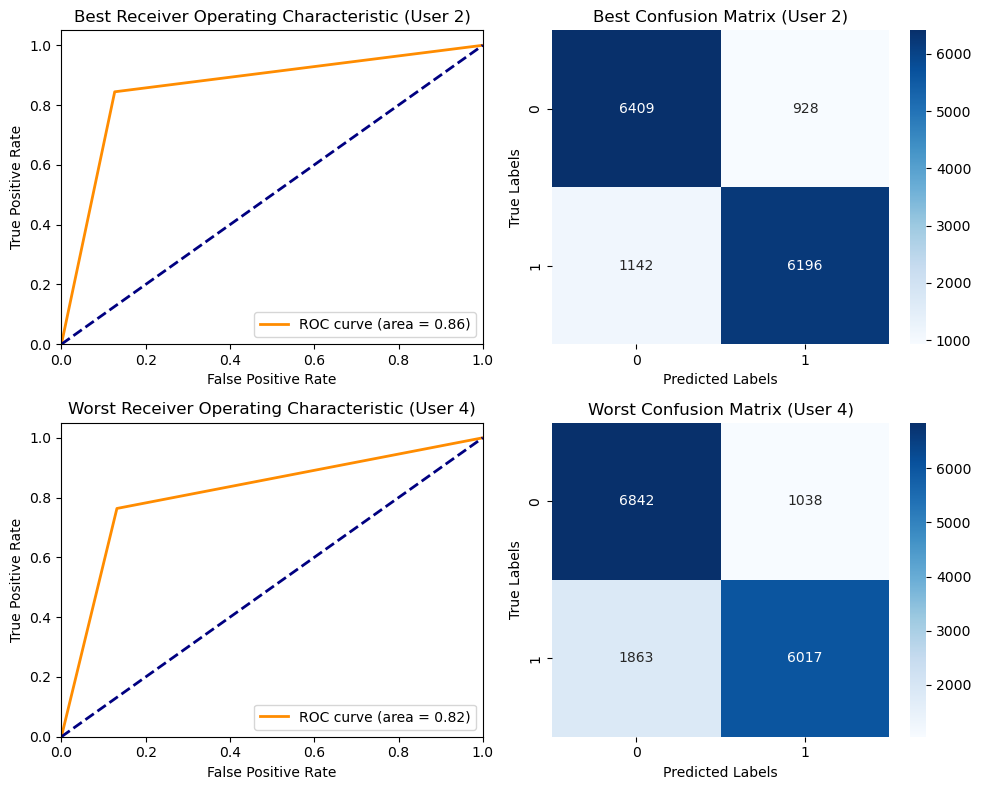

In [32]:
best_roc_auc = 0
worst_roc_auc = 1
mean_roc_auc = 0

best_user, worst_user = None, None
best_fpr, best_tpr, worst_fpr, worst_tpr = None, None, None, None
best_cm, worst_cm = None, None

for i in range(num_classes):
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    predictions = predictions_list[i]

    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)
    mean_roc_auc += roc_auc

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_user = i
        best_fpr, best_tpr = fpr, tpr
        best_cm = confusion_matrix(y_test, predictions)

    if roc_auc < worst_roc_auc:
        worst_roc_auc = roc_auc
        worst_user = i
        worst_fpr, worst_tpr = fpr, tpr
        worst_cm = confusion_matrix(y_test, predictions)

mean_roc_auc /= num_classes

print("Mean ROC AUC: ", round(mean_roc_auc, 2))

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

plt.sca(axes[0, 0])
plt.plot(best_fpr, best_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {best_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Best Receiver Operating Characteristic (User {best_user})')
plt.legend(loc="lower right")

plt.sca(axes[0, 1])
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Best Confusion Matrix (User {best_user})')

plt.sca(axes[1, 0])
plt.plot(worst_fpr, worst_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {worst_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Worst Receiver Operating Characteristic (User {worst_user})')
plt.legend(loc="lower right")

plt.sca(axes[1, 1])
sns.heatmap(worst_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Worst Confusion Matrix (User {worst_user})')

plt.tight_layout()
plt.show()

# **K Nearest Neighbors**

### Hyperparameters tuning

#### Randomized Search

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import random

best_models_random = []

hyperparams = {
        #'n_neighbors': list(range(2, 50)),
        #'leaf_size': list(range(1, 31)),
        #'weights': ['uniform', 'distance'],
        #'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'p': [1, 2, 3]
    }

classes = list(range(num_classes))
random.shuffle(classes)
random_classes = classes[:5]

for i in random_classes:
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    knn = KNeighborsClassifier()

    random_search = RandomizedSearchCV(knn, hyperparams, cv=5, scoring='accuracy', n_jobs=-1, n_iter=10)
    random_search.fit(X_train, y_train)

    print('User ', i)
    print('Best hyperparams:', random_search.best_params_)
    print('Best score: ', random_search.best_score_)

    best_model = random_search.best_estimator_
    best_models_random.append(best_model)

    predictions = best_model.predict(X_test)

    print(classification_report(y_test, predictions))

C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


#### Grid Search

In [ ]:
best_models_grid = []

hyperparams = {
    'n_neighbors': list(range(2, 21)),
    'leaf_size': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2, 3]
}

for i in range(num_classes):
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    knn = KNeighborsClassifier()

    f1 = make_scorer(f1_score)

    grid_search = GridSearchCV(knn, hyperparams, cv=5, scoring=f1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print('User ', i)
    print('Best hyperparams:', grid_search.best_params_)
    print('Best score: ', grid_search.best_score_)

    best_model = grid_search.best_estimator_
    best_models_grid.append(best_model)

    predictions = best_model.predict(X_test)

    print(classification_report(y_test, predictions))

### Final model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# TODO: default hyperparams

hyperparams = {}

predictions_list = []

for i in range(num_classes):
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    knn = KNeighborsClassifier(**hyperparams)
    knn.fit(X_train, y_train)

    predictions = knn.predict(X_test)
    predictions_list.append(predictions)

    f2_score = fbeta_score(y_test, predictions, beta=2)

    print("User: ", i)
    print(classification_report(y_test, predictions))
    print("F2 score: ", round(f2_score, 2))

In [ ]:
best_roc_auc = 0
worst_roc_auc = 1
mean_roc_auc = 0

best_user, worst_user = None, None
best_fpr, best_tpr, worst_fpr, worst_tpr = None, None, None, None
best_cm, worst_cm = None, None

for i in range(num_classes):
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    predictions = predictions_list[i]

    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)
    mean_roc_auc += roc_auc

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_user = i
        best_fpr, best_tpr = fpr, tpr
        best_cm = confusion_matrix(y_test, predictions)

    if roc_auc < worst_roc_auc:
        worst_roc_auc = roc_auc
        worst_user = i
        worst_fpr, worst_tpr = fpr, tpr
        worst_cm = confusion_matrix(y_test, predictions)

mean_roc_auc /= num_classes

print("Mean ROC AUC: ", round(mean_roc_auc, 2))

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

plt.sca(axes[0, 0])
plt.plot(best_fpr, best_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {best_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Best Receiver Operating Characteristic (User {best_user})')
plt.legend(loc="lower right")

plt.sca(axes[0, 1])
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Best Confusion Matrix (User {best_user})')

plt.sca(axes[1, 0])
plt.plot(worst_fpr, worst_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {worst_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Worst Receiver Operating Characteristic (User {worst_user})')
plt.legend(loc="lower right")

plt.sca(axes[1, 1])
sns.heatmap(worst_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Worst Confusion Matrix (User {worst_user})')

plt.tight_layout()
plt.show()

# **SVM**


### Hyperparameters tuning


#### Randomized Search

In [ ]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import random

best_models_random = []

hyperparams = {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    }

classes = list(range(num_classes))
random.shuffle(classes)
random_classes = classes[:5]

for i in random_classes:
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    svm_ = model = svm.SVC()

    random_search = RandomizedSearchCV(svm_, hyperparams, cv=5, scoring='accuracy', n_jobs=-1, n_iter=10)
    random_search.fit(X_train, y_train)

    print('User ', i)
    print('Best hyperparams:', random_search.best_params_)
    print('Best score: ', random_search.best_score_)

    best_model = random_search.best_estimator_
    best_models_random.append(best_model)

    predictions = best_model.predict(X_test)

    print(classification_report(y_test, predictions))

# **Neural Network**

In [ ]:
%pip install tensorflow

#### Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

predictions_list = []
history_list = []

X_test_list_nn = []
y_test_list_nn = []

for i in range(num_classes):
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    # train: 70%, validation: 20%, test: 10%
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, stratify=y_temp) 

    X_test_list_nn.append(X_test)
    y_test_list_nn.append(y_test)

    model = Sequential()

    model.add(Dense(300, input_dim=33, activation='relu')) # input layer - input_dim = number of features
    model.add(Dropout(0.2))
    model.add(Dense(300, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid')) # output layer - 1 neuron as it is binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=50, verbose=0)
    history_list.append(history)

    predictions = model.predict(X_test)
    predictions = (predictions > 0.5).astype(int)
    predictions_list.append(predictions)

    f2_score = fbeta_score(y_test, predictions, beta=2)

    print("User: ", i)
    print(classification_report(y_test, predictions))
    print("F2 score: ", round(f2_score, 2))

#### Diagrams

In [ ]:
best_roc_auc = 0
worst_roc_auc = 1
mean_roc_auc = 0

best_user, worst_user = None, None
best_fpr, best_tpr, worst_fpr, worst_tpr = None, None, None, None
best_cm, worst_cm = None, None
best_history, worst_history = None, None

for i in range(num_classes):
    X_train = X_train_list[i]
    X_test = X_test_list_nn[i]
    y_train = y_train_list[i]
    y_test_ = y_test_list_nn[i]

    predictions = predictions_list[i]
    history = history_list[i]

    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)
    mean_roc_auc += roc_auc

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_user = i
        best_fpr, best_tpr = fpr, tpr
        best_cm = confusion_matrix(y_test, predictions)
        best_history = history

    if roc_auc < worst_roc_auc:
        worst_roc_auc = roc_auc
        worst_user = i
        worst_fpr, worst_tpr = fpr, tpr
        worst_cm = confusion_matrix(y_test, predictions)
        worst_history = history

mean_roc_auc /= num_classes

print("Mean ROC AUC: ", round(mean_roc_auc, 2))

fig, axes = plt.subplots(2, 4, figsize=(20, 8))

plt.sca(axes[0, 0])
plt.plot(best_fpr, best_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {best_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Best Receiver Operating Characteristic (User {best_user})')
plt.legend(loc="lower right")

plt.sca(axes[0, 1])
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Best Confusion Matrix (User {best_user})')

plt.sca(axes[0, 2])
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.sca(axes[0, 3])
plt.plot(best_history.history['accuracy'], label='Training Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.sca(axes[1, 0])
plt.plot(worst_fpr, worst_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {worst_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Worst Receiver Operating Characteristic (User {worst_user})')
plt.legend(loc="lower right")

plt.sca(axes[1, 1])
sns.heatmap(worst_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Worst Confusion Matrix (User {worst_user})')

plt.sca(axes[1, 2])
plt.plot(worst_history.history['loss'], label='Training Loss')
plt.plot(worst_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.sca(axes[1, 3])
plt.plot(worst_history.history['accuracy'], label='Training Accuracy')
plt.plot(worst_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()